# Composable Overlay Tutorial (sw)

In the second part of the tutorial, you will learn how to use the composable overlay you just created. You will also feed the design with different tones (sine waves at a particular frequency) and see the frequency domain.

Import the necessary packages

In [1]:
from pynq import Overlay, allocate
import matplotlib.pyplot as plt
import pynq_composable
import numpy as np
import fir

## Download the overlay onto the FPGA

The process to download a composable overlay onto your board is the same as any overlay. We use `pynq.Overlay`.

In [2]:
ol = Overlay("fir.bit")

To create the composable overlay object, we grab a handle to hierarchy in our design. We assign the Composable object to `cfilter`.

In [3]:
cfilter = ol.filter

You can verify that `cfilter` object is inheriting from `pynq.DefaultHierarchy` and it is assigned the Composable driver. 
This assignation is done automatically, as our overlay meets the two key characteristics of a composable overlay.

1. It has an AXI4-Stream Switch
2. The composable logic is wrapped in a hierarchy

In [4]:
print(f"Parent class: {cfilter.__class__.__bases__}, driver: {type(cfilter)}")

Parent class: (<class 'pynq.overlay.DefaultHierarchy'>,), driver: <class 'pynq_composable.composable.Composable'>


We can explore the IP available for composition using the `c_dict` attribute of the `Composable` class.

As displayed below, the design has four FIR filters that are available.

- Bandpass
- Lowpass
- Highpass
- Stoppass

There is also a FIFO. 
Note the labels in square brackets indicate that all IP are `loaded`. The `default` label indicate the sources and sinks of data in our composable regions. 
In the case of DFX IP you will see `unloaded` or `loaded` depending on the state.

In [5]:
cfilter.c_dict

{'fir_stopband': {'ci': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'pi': [5]},
 'axis_data_fifo': {'pi': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'axis_data_fifo',
  'ci': [5]},
 'fir_lowpass': {'ci': [1],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'pi': [3]},
 'fir_highpass': {'ci': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'pi': [4]},
 'fir_bandpass': {'pi': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'fir_compiler',
  'ci': [4]},
 'ps_in': {'dfx': False,
  'loaded': True,
  'modtype': 'axi_dma',
  'ci': [3],
  'default': True,
  'fullpath': 'axi_dma'},
 'ps_out': {'pi': [1],
  'dfx': False,
  'loaded': True,
  'modtype': 'axi_dma',
  'default': True,
  'fullpath': 'axi_dma'}}

## FIR filters Frequency response

The easiest way to understand FIR filters is to look at their frequency response. In the cell below, we use the `fir.py` companion Python file to plot the frequency response for the four FIR filters. 

Note that all filters are designed with a sampling frequency of 44,100 Hz.

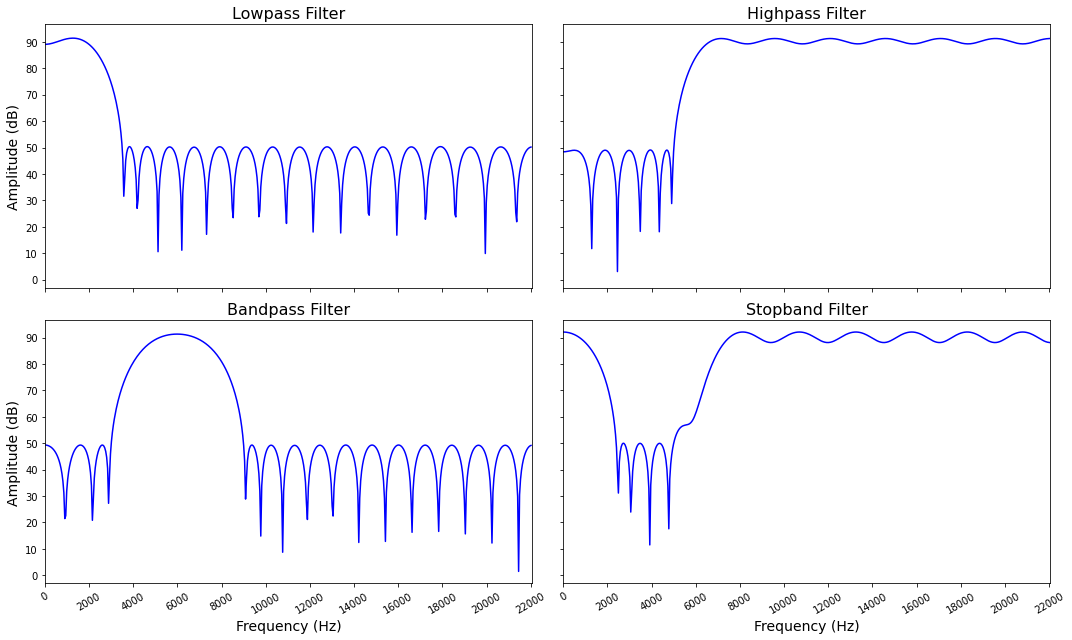

In [6]:
f = fir.Filters()

f.plot()

## Create tones

Let us create single-frequency tones to test the FIR filters.

We will create 5 tones with the following frequencies 1) 1,000 Hz; 2) 4,000 Hz, 3) 6,000 Hz, 4) 8,000 Hz and 5) 17,357 Hz

In [7]:
f0, f1, f2, f3, f4 = 1_000, 4_000, 6_000, 8_000, 17_357
samples = 4_096
fs = 44_100

ix = np.arange(samples)
tone_0 = np.int32( 800 * np.sin(2 * np.pi * f0 * ix / fs))
tone_1 = np.int32( 1_200 * np.sin(2 * np.pi * f1 * ix / fs))
tone_2 = np.int32( -555 * np.sin(2 * np.pi * f2 * ix / fs))
tone_3 = np.int32( 168 * np.sin(2 * np.pi * f3 * ix / fs))
tone_4 = np.int32( -234 * np.sin(2 * np.pi * f4 * ix / fs))

The following cell plots the time response of the five tones

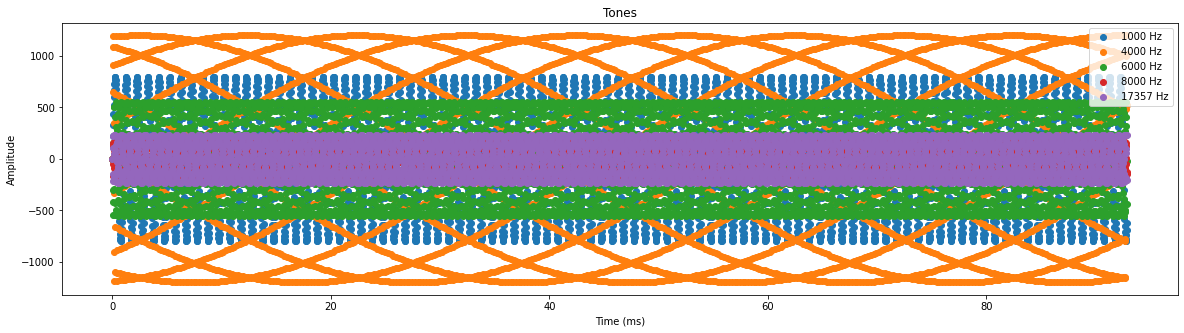

In [8]:
plt.figure(figsize=(20, 5));
plt.plot(ix*1000/fs, tone_0, 'o', label = str(f0) + ' Hz');
plt.plot(ix*1000/fs, tone_1, 'o', label = str(f1) + ' Hz');
plt.plot(ix*1000/fs, tone_2, 'o', label = str(f2) + ' Hz');
plt.plot(ix*1000/fs, tone_3, 'o', label = str(f3) + ' Hz');
plt.plot(ix*1000/fs, tone_4, 'o', label = str(f4) + ' Hz');
plt.title("Tones");
plt.xlabel("Time (ms)");
plt.ylabel("Amplitude");
plt.legend();

The frequency domain is a much more useful way of looking at this information.

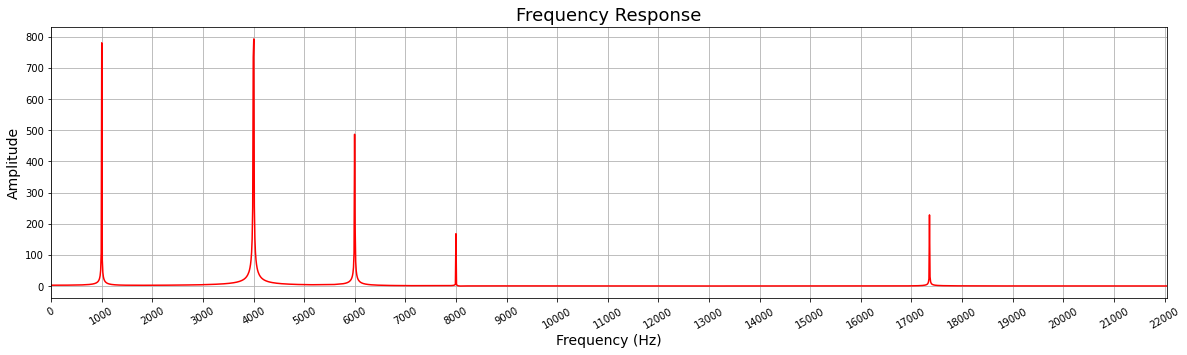

In [9]:
tones = tone_0 + tone_1 + tone_2 + tone_3 + tone_4
fir.plot_fft(tones)

## Compose

It is now time to compose, let us start with a low pass filter. The `.compose` method takes a list of IP and configures the AXI4-Stream Switch to achieve this. 
The data source is the first element in the list, and the data sink is the last element in the list. The data will flow from left to right. 

After using the compose method, we can use the `.graph` attribute to visualize the composed pipeline.

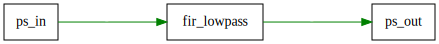

In [10]:
cfilter.compose([cfilter.ps_in, cfilter.fir_lowpass, cfilter.ps_out])

cfilter.graph

After we have our pipeline, we can feed the pipeline with our tones. For this, grab handlers to the DMA send and receive channels

In [11]:
dma_send = ol.axi_dma.sendchannel
dma_recv = ol.axi_dma.recvchannel

We will allocate buffers for #samples and assign the tones signal to the input buffer

In [12]:
input_buffer = allocate(shape=(samples,), dtype=np.int32)
output_buffer = allocate(shape=(samples,), dtype=np.int32)

input_buffer[:] = tones

Start the DMA transfer and wait for the results

In [13]:
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Plot the frequency response. As you can see from the plot only the tone with frequency 1000 Hz remains. There is a small spike around 4,000 Hz but is negligible

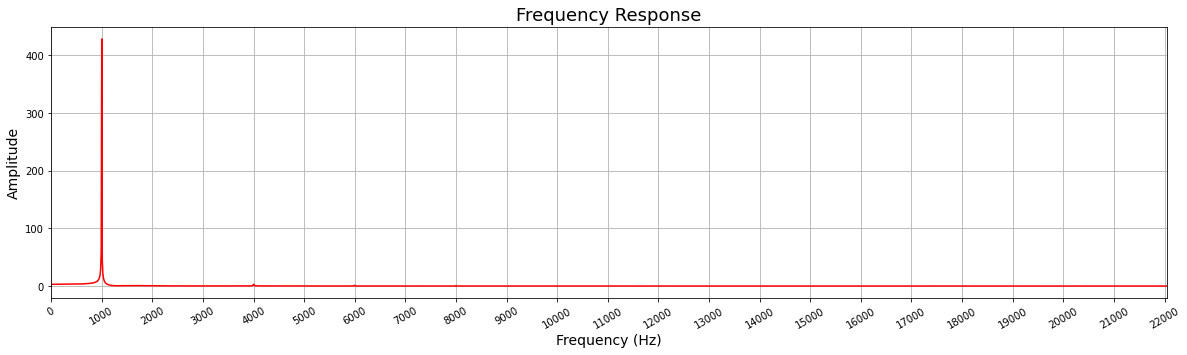

In [14]:
fir.plot_fft(output_buffer)

### High pass filter

Now let us compose a high pass filter

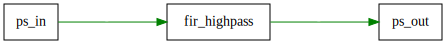

In [15]:
cfilter.compose([cfilter.ps_in, cfilter.fir_highpass, cfilter.ps_out])
cfilter.graph

Start DMA. Note that we do not need to assign values to the input_buffer as nothing changes

In [16]:
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Plot the frequency response. The cutoff frequency of this filter is 5,000 Hz and as you expect everything below that frequency is attenuated.

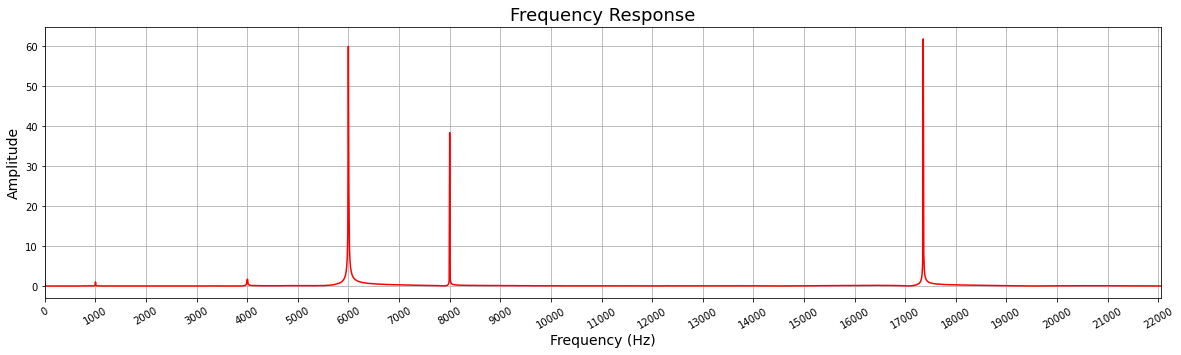

In [17]:
fir.plot_fft(output_buffer)

### Reader's assignments

It is now time for you to compose designs with the two remaining FIR filters and analyze the frequency domain.

#### Exercise 1. Compose a band pass filter and plot frequency response

In [ ]:
# Code goes here

#### Exercise 2. Compose a stop band filter and plot frequency response

In [ ]:
# Code goes here

### Compose with two filters

So far we have used one filter at the time, but with the composable overlay methodology we can daisy-chain them.

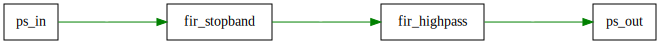

In [18]:
cfilter.compose([cfilter.ps_in, cfilter.fir_stopband, cfilter.fir_highpass, cfilter.ps_out])
cfilter.graph

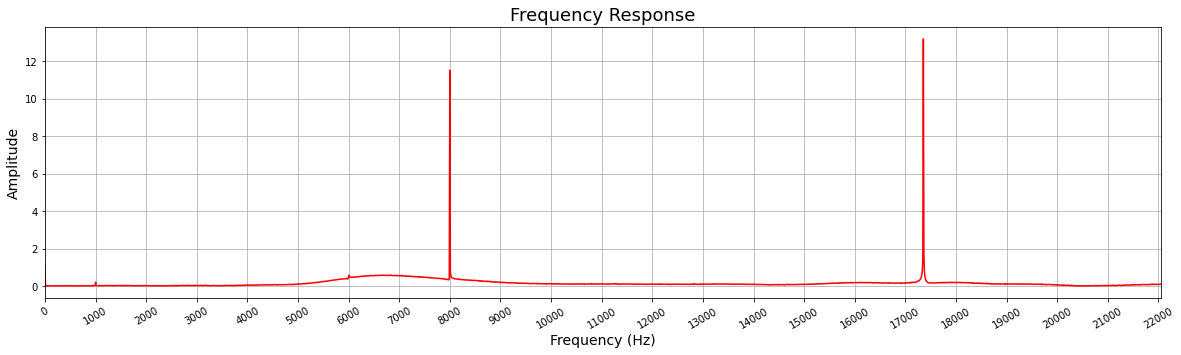

In [19]:
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

fir.plot_fft(output_buffer)

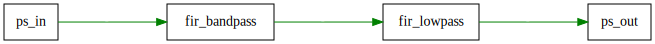

In [20]:
cfilter.compose([cfilter.ps_in, cfilter.fir_bandpass, cfilter.fir_lowpass, cfilter.ps_out])
cfilter.graph

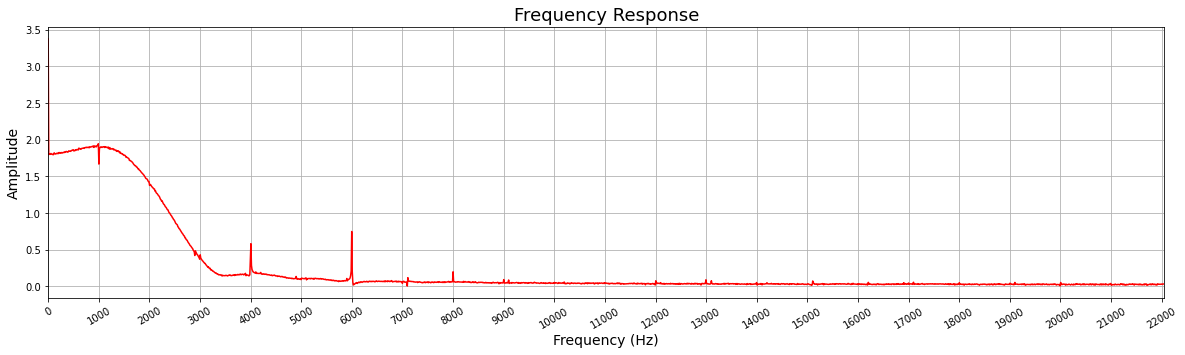

In [21]:
dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

fir.plot_fft(output_buffer)

As you can observe, the combination of the Stop Band and High Pass filter gives a meaningful result. On the other hand, the combination of the Band Pass and Low Pass filters attenuate all the tones almost to 0. 

When daisy-chaining IP/functions the order of the IP (FIR filter in this case) alters the output of the pipeline. In some cases some combination does not make sense.

### Reader's assignment

You can now try to compose designs daisy-chaining two or more filter. You can also go to Vivado and change the characteristics of the filter so the combination makes sense. Alternatively, you can add more filters in the Vivado design

## Working with real audio

<div class="alert alert-heading alert-warning">
    <h4 class="alert-heading">Warning:</h4>

Before continuing, make sure you install the necessary packages and files. To do so, follow the instructions in the [Appendix](#appendix)
</div>

Open audio file and get numpy array

In [ ]:
from audio2numpy import open_audio
from IPython.display import Audio
fp = "clip_02_newsflash.mp3"
signal, sampling_rate = open_audio(fp)

Transpose the matrix to separate the right and left channels

In [ ]:
samples= np.transpose(signal)

Allocate buffers and assign half of the samples to the input buffer, we will only work with the first 6 seconds of the audio file

In [ ]:
shape = (len(samples[0])//2, )
input_buffer = allocate(shape=shape, dtype=np.int32)
output_buffer = allocate(shape=shape, dtype=np.int32)

We will convert the floating point values to integers by multiplying by 100,000 and then casting the array to integers. Note that the FIR filters in our design work with integers.

In [ ]:
input_buffer[:] = np.int32(samples[0][0:len(samples[0])//2] * 100_000)

Generate Audio widget for the samples, you can play this directly from the web browser

In [ ]:
Audio(input_buffer, rate=sampling_rate)

Compose a desing with a high band pass filter

In [ ]:
cfilter.compose([cfilter.ps_in, cfilter.fir_bandpass, cfilter.ps_out])

dma_recv.transfer(output_buffer)
dma_send.transfer(input_buffer)
dma_send.wait()
dma_recv.wait()

Generate audio widget

In [ ]:
Audio(output_buffer, rate=sampling_rate)

### Reader's assignment

Explore the different FIR filters with the audio file.

In [ ]:
# Code goes here

## Conclusion

In the second part of this tutorial you learnt how to interact with a composable overlay and how to compose your own design. You feed tones to the filters and analyzed the frequency response. Finally, you worked with real audio and applied different filters and you were able to listen to the filtered audio directly from the notebook.

## Appendix: required packages <a class="anchor" id="appendix"></a>

To work with real audio we will use the [`audio2numpy` package](https://pypi.org/project/audio2numpy/), this package depends on `ffmpeg`. We would also need an audio file, for this we will download a file from PixaBay

1. Install ffmpeg

In [ ]:
!sudo apt-get install ffmpeg

2. Install audio2numpy

In [ ]:
!python3 -m pip install audio2numpy

3. Download [audio file from PixaBay](https://pixabay.com/music/introoutro-clip-02-newsflash-446/)

In [ ]:
!wget https://cdn.pixabay.com/download/audio/2020/08/04/audio_5772dbca6c.mp3?filename=clip_02_newsflash-446.mp3 -O clip_02_newsflash.mp3

----

Copyright &copy; 2022 Xilinx, Inc

SPDX-License-Identifier: BSD-3-Clause